<a href="https://colab.research.google.com/github/KonsumGandalf/proccessMining/blob/colab/proccessMining/src/data/course_python_data/Copy_of_3_3ProcessDiscovery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install pm4py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import pareto
import seaborn as sns

import pm4py
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter

     |████████████████████████████████| 1.7 MB 14.7 MB/s 
  Created wheel for stringdist: filename=StringDist-1.0.9-cp37-cp37m-linux_x86_64.whl size=23592 sha256=77fa5d8fce19986032094123c1f3bfb83b3e88112aaef8a2aa773aa64d30926a
  Stored in directory: /root/.cache/pip/wheels/d7/9c/d4/63bc3d8931de0980b9e4a724dea290bb40b8b1b2bd6227c8da
Successfully built stringdist


In [ ]:
log_csv = pd.read_csv('https://raw.githubusercontent.com/paoloceravolo/PM-Regensburg/main/ArtificialPatientTreatment.csv', sep=',')
log_csv = dataframe_utils.convert_timestamp_columns_in_df(log_csv)
log_csv

,patient,action,resource,datetime
0,patient0,First consult,Dr. Anna,2017-01-02 11:40:11+00:00
1,patient0,Blood test,Lab,2017-01-02 12:47:33+00:00
2,patient0,Physical test,Nurse Jesse,2017-01-02 12:53:50+00:00
3,patient0,Second consult,Dr. Anna,2017-01-02 16:21:06+00:00
4,patient0,Surgery,Dr. Charlie,2017-01-05 13:23:09+00:00
...,...,...,...,...
685,patient99,X-ray scan,Team 2,2017-05-25 11:03:27+00:00
686,patient99,Physical test,Nurse Corey,2017-05-25 11:55:24+00:00
687,patient99,Second consult,Dr. Anna,2017-05-29 15:12:39+00:00
688,patient99,Medicine,Pharmacy,2017-05-29 16:17:13+00:00


In [ ]:
# Create a pivot table of the start and end timestamps associated with each case

case_starts_ends = log_csv.pivot_table(index = 'patient', aggfunc={'datetime': ['min', 'max']})
case_starts_ends = case_starts_ends.reset_index()
case_starts_ends.columns = ['patient', 'caseend', 'casestart']

# merge with the main ebent log data so that for each row we have the start and end times
log_csv = log_csv.merge(case_starts_ends, on='patient')

# Calculate the relative time by subtracting the process start time from the event timestamp
log_csv['cumulativetime'] = log_csv['datetime'] - log_csv['casestart']

# convert relative times to more friendly measures
## seconds
log_csv['cumulativetime_s'] = log_csv['cumulativetime'].dt.seconds + 86400*log_csv['cumulativetime'].dt.days
## days
log_csv['cumulativedays'] = log_csv['cumulativetime'].dt.days

log_csv

,patient,action,resource,datetime,caseend,casestart,cumulativetime,cumulativetime_s,cumulativedays
0,patient0,First consult,Dr. Anna,2017-01-02 11:40:11+00:00,2017-01-09 08:29:28+00:00,2017-01-02 11:40:11+00:00,0 days 00:00:00,0,0
1,patient0,Blood test,Lab,2017-01-02 12:47:33+00:00,2017-01-09 08:29:28+00:00,2017-01-02 11:40:11+00:00,0 days 01:07:22,4042,0
2,patient0,Physical test,Nurse Jesse,2017-01-02 12:53:50+00:00,2017-01-09 08:29:28+00:00,2017-01-02 11:40:11+00:00,0 days 01:13:39,4419,0
3,patient0,Second consult,Dr. Anna,2017-01-02 16:21:06+00:00,2017-01-09 08:29:28+00:00,2017-01-02 11:40:11+00:00,0 days 04:40:55,16855,0
4,patient0,Surgery,Dr. Charlie,2017-01-05 13:23:09+00:00,2017-01-09 08:29:28+00:00,2017-01-02 11:40:11+00:00,3 days 01:42:58,265378,3
...,...,...,...,...,...,...,...,...,...
685,patient99,X-ray scan,Team 2,2017-05-25 11:03:27+00:00,2017-05-31 12:46:43+00:00,2017-05-18 11:57:11+00:00,6 days 23:06:16,601576,6
686,patient99,Physical test,Nurse Corey,2017-05-25 11:55:24+00:00,2017-05-31 12:46:43+00:00,2017-05-18 11:57:11+00:00,6 days 23:58:13,604693,6
687,patient99,Second consult,Dr. Anna,2017-05-29 15:12:39+00:00,2017-05-31 12:46:43+00:00,2017-05-18 11:57:11+00:00,11 days 03:15:28,962128,11
688,patient99,Medicine,Pharmacy,2017-05-29 16:17:13+00:00,2017-05-31 12:46:43+00:00,2017-05-18 11:57:11+00:00,11 days 04:20:02,966002,11


<Figure size 720x720 with 0 Axes>

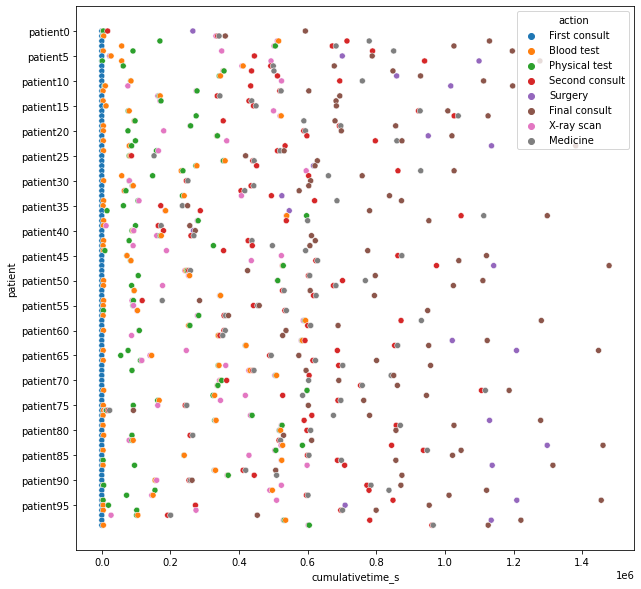

<Figure size 720x720 with 0 Axes>

In [ ]:
# Get an array of patient labels for the y axis - for graph labelling purposes
patientnums = [int(e) for e in log_csv['patient'].apply(lambda x: x.strip('patient'))]


## Plor a scatter plot of patient events over relative time
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x=log_csv['cumulativetime_s'],
                     y=log_csv['patient'], hue=log_csv['action'])
## Set y axis tick so that you only show every 5 patinet - for readability
plt.yticks(np.arange(min(patientnums), max(patientnums)+1, 5))

plt.figure(figsize=(10,10))

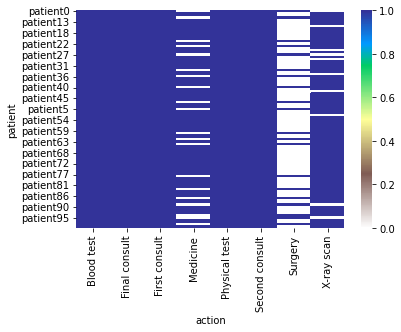

In [ ]:
## Create a table giving the number of cases in which each event is present
patient_events = pd.crosstab(log_csv['patient'], log_csv['action'])
## Visualize in a heatmap
sns.heatmap(patient_events, cmap="terrain_r")

In [ ]:
# compy to the naming stadard of PM4PY

log_csv.rename(columns={'datetime': 'time:timestamp', 'patient': 'case:concept:name', 'action': 'concept:name', 'resource': 'org:resource'}, inplace=True)

# convert to log format
log = log_converter.apply(log_csv)

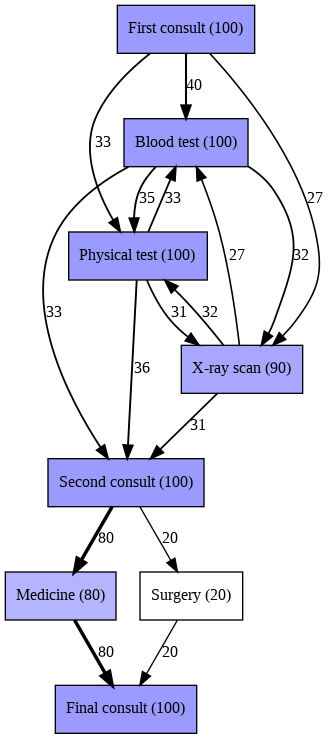

In [ ]:
## Import the dfg_discovery algorithm
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
## Import the dfg visulation object
from pm4py.visualization.dfg import visualizer as dfg_visualization
#Create graph from log
dfg = dfg_discovery.apply(log)
# visualize
gviz = dfg_visualization.apply(dfg, log=log, variant = dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecatedWarning: apply is deprecated as of 2.2.5 and will be removed in 3.0.0. please use pm4py.visualization.petri_net.algorithm instead
  


replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

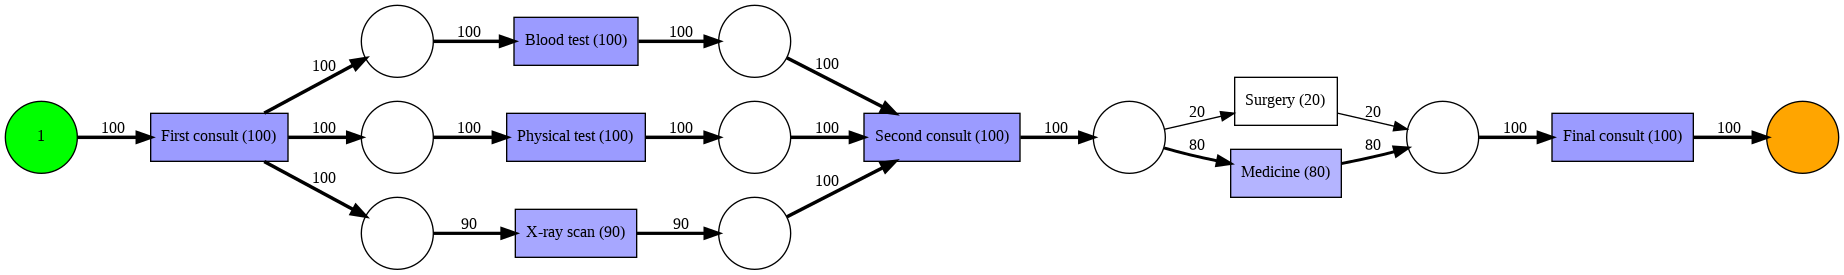

In [ ]:
## Import the alpha_miner algorithm
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
net, inital_marking, final_marking = alpha_miner.apply(log)

## Import the petrinet visualizer object
from pm4py.visualization.petrinet import visualizer as pn_visualizer
# Visualize
gviz = pn_visualizer.apply(net, inital_marking, final_marking, variant = pn_visualizer.Variants.FREQUENCY, log=log)
pn_visualizer.view(gviz)

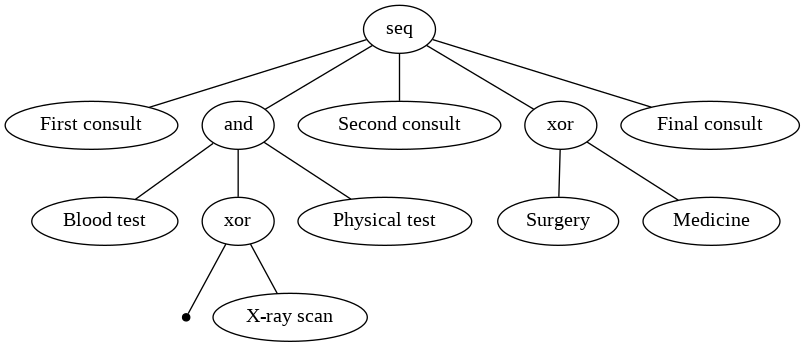

In [ ]:
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
# Discover process tree using inductive miner
tree = inductive_miner.apply_tree(log)

from pm4py.visualization.process_tree import visualizer as pt_visualizer
gviz = pt_visualizer.apply(tree, parameters={pt_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "png"})
pt_visualizer.view(gviz)

from pm4py.objects.conversion.process_tree import converter as pt_converter
net, inital_marking, final_marking = pt_converter.apply(tree)

